In [5]:
import scipy
import sklearn
import pyemma
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator
from matplotlib import colormaps as cmaps



# Main analyses

In [ ]:
def plot_transition_matrix(msm,num_dists= 5,zoom=None,save_name = ""):
    '''
    Makes a plot of the transition matrix colored by the magnitude of the value of each element in the matrix.
    Discretizes the color map into "num_dists" bands.
    '''
    
    bounds = np.linspace(0,1,num_dists)
    means = msm.sample_mean("transition_matrix")
    
    cmap = plt.get_cmap("viridis")
    colors = ["navy","cornflowerblue","rebeccapurple","forestgreen","firebrick"]
    num_bins = num_dists
    labels = [0.0,0.2,0.4,0.6,0.8,1.0]
    print(f"Bounds {bounds}, Labels {labels}")
    plt.figure(figsize=(8,8))
    
    if zoom is not None:
        means = means[zoom[0][0]:zoom[1][0],zoom[0][1]:zoom[1][1]]
    means.flatten()


    bin_indices = np.digitize(means, bounds) - 1

    # Map each value in the matrix to a bin color
    colors = plt.cm.viridis(np.linspace(0, 1, num_dists) )
    
    color_mapped_matrix = colors[bin_indices].reshape(means.shape + (4,))  

    plt.rcParams.update({"font.size": 16})
    plt.rcParams.update({"font.family": "Helvetica"})
    plt.rcParams.update({"font.style": "normal"})
    
    
    ax = plt.gca()
    ax.imshow(color_mapped_matrix, aspect='auto')
    ax.yaxis.set_minor_locator(MultipleLocator(1))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    if zoom is not None:
        xticks = np.arange(0,zoom[1][0]-zoom[0][0],5)
        ax.set_xticks(xticks,labels = xticks+zoom[0][0],rotation = 30)
        yticks = np.arange(0,zoom[1][1]-zoom[0][1],5)
        ax.set_yticks(yticks,labels = yticks+zoom[0][1])
    
    for axis in ["bottom", "top", "left", "right"]:
        ax.spines[axis].set_linewidth(1.6)
    ax.xaxis.set_tick_params(width=1.6, length=5)
    ax.yaxis.set_tick_params(width=1.6, length=5)    
    plt.savefig(save_name+f"_matrix.svg")
    plt.show()

In [ ]:
def plot_transition_matrix_spy(msm,save_name = ""):
    '''
    Makes a spy plot of the transition matrix which shades elements which are nonzero.
    '''
    plt.rcParams.update({"font.size": 16})
    plt.rcParams.update({"font.family": "Helvetica"})
    plt.rcParams.update({"font.style": "normal"})
    plt.figure(figsize=(8,8))
    plt.spy(msm.sample_mean("transition_matrix"),precision=1e-6,)
    
    ax = plt.gca()
    ax.xaxis.set_ticks_position('bottom') 
    ax.xaxis.set_label_position('bottom')
    for axis in ["bottom", "top", "left", "right"]:
        ax.spines[axis].set_linewidth(1.6)
    ax.xaxis.set_tick_params(width=1.6, length=5)
    ax.yaxis.set_tick_params(width=1.6, length=5)    
    plt.savefig(save_name+f"_spy.svg")
    plt.show()
        

In [6]:
def plot_transition_confidence_format(msm,cutoff = 0.0,logy=True,num_dists= 5,dist_boundaries = None,save_name="",num_bins = 80,xmax=None):

    '''
    Makes histogram(s) of the relative uncertainty (std.dev/mean) of the sampled transition matrices for the Bayesian Markov Models.
    Can separate the uncertainty distributions into different colors based on the magnitude of the transition matrix elements.
    '''
    uncertainties = msm.sample_std("transition_matrix")
    means = msm.sample_mean("transition_matrix")
    mask = means >= cutoff
    
    print(f"Using {np.sum(mask)} of {uncertainties.size} values in the transition matrix")
    
    #Convert to Relative Uncertainty
    uncertainties[mask] = np.divide(uncertainties[mask],means[mask])
    
    print("Mean Uncertainty is:",np.mean(uncertainties[mask]))
    
    if dist_boundaries is None:
        bounds = np.linspace(0,1,num_dists+1)
    else: 
        bounds = dist_boundaries
    
    
    plt.figure(figsize=(7,5))
    
    cmap = plt.get_cmap("viridis")
    colors = ["navy","cornflowerblue","rebeccapurple","forestgreen","firebrick"]
    num_bins = num_bins
    labels = [0.0,0.2,0.4,0.6,0.8,1.0]
    print(f"Bounds {bounds}, Labels {labels}")
    if xmax is None:
        xmax = np.max(uncertainties)
    
    for i in range(num_dists):
        selection = (means > bounds[i]) & (means <= bounds[i+1])
        
        counts, bins = np.histogram(uncertainties[mask & selection], bins=np.linspace(0,xmax,num_bins))
    
        plt.hist(
            bins[:-1],
            bins,
            weights=counts,
            rwidth=1.0,
            #edgecolor="black",
            color=cmap(bounds[i]),#colors[i],
            label=f"{labels[i]}–{labels[i+1]}",
            alpha = 1.0,
            density=False,
        )

    plt.title(f"{save_name} Relative Uncertainty")
    plt.xlabel("Relative uncertainty")
    plt.ylabel("Counts")
    plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
    plt.xlim(-0.05,xmax)
    ax = plt.gca()
    plt.legend()
    if logy:
        ax.set_yscale('log')
    ax.grid(color="grey", linestyle=":", linewidth=0.5,axis="y")
    for axis in ["bottom", "top", "left", "right"]:
        ax.spines[axis].set_linewidth(1.6)
    ax.xaxis.set_tick_params(width=1.6, length=5)
    ax.yaxis.set_tick_params(width=1.6, length=5)    
    plt.savefig(save_name+f"_uncertainty_{cutoff}_format_logy-{logy}_xmax-{xmax}.png",dpi=300)
    plt.show()
    

In [ ]:
def stationary_distributions(msm,save_name = ""):
    '''
    Plots the stationary distribution of the markov model's transition matrix.
    '''
    plt.rcParams.update({"font.size": 16})
    plt.rcParams.update({"font.family": "Helvetica"})
    plt.rcParams.update({"font.style": "normal"})
    
    
    pi = msm.pi
    print(pi)
    
    indices = np.argsort(pi)[::-1]
    cutoff = 0
    #Select only a number of states that have > 1% populations
    while pi[indices[cutoff]] > 0.01:
        cutoff +=1 
    
    xticklabels = [f"{i}" for i in indices[:cutoff]]
    plt.figure(figsize=(10,5))
    plt.bar(np.arange(cutoff),pi[indices[:cutoff]],width = 0.8,color = "firebrick")
    plt.title(f"{save_name} Stationary Distribution")
    plt.xlabel("State Number")
    plt.ylabel("Population")

    ax = plt.gca()
    ax.set_xticks(ticks = np.arange(cutoff),labels = xticklabels,rotation = 35)
    ax.set_yticks(ticks = np.linspace(0,0.1,6))
    ax.yaxis.set_minor_locator(MultipleLocator(0.002))
    ax.grid(color="grey", linestyle=":", linewidth=0.5,axis="y")
    for axis in ["bottom", "top", "left", "right"]:
        ax.spines[axis].set_linewidth(1.6)
    ax.xaxis.set_tick_params(width=1.6, length=5)
    ax.yaxis.set_tick_params(width=1.6, length=5)

    
    plt.savefig(save_name+"_stationary.png",dpi=300)
    
    np.save(f"./pi_{save_name}.npy",pi)
    np.save(f"./pi_indices_{save_name}.npy",indices)
    
    

# Hidden Bayesian 5.0

In [184]:
file_path = "/Users/marcdescoteaux/Documents/04_Courses/AM207_StochasticMethods/Project/24_11_27_Analyze/models/HiddenBayesian_5.0/nohalo_100ps_every1ps_hidden_5.0/model.file"
save_name = "HiddenBayesian_5.0"
model = pyemma.load(file_path)


In [275]:
save_name = "HiddenBayesian_5.0"

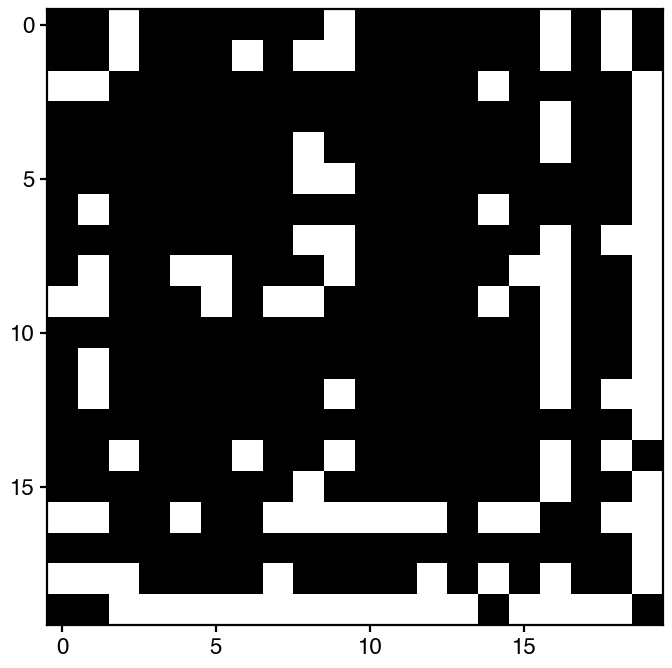

In [276]:
plot_transition_matrix_spy(model,save_name=save_name)

Bounds [0.   0.25 0.5  0.75 1.  ], Labels [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]


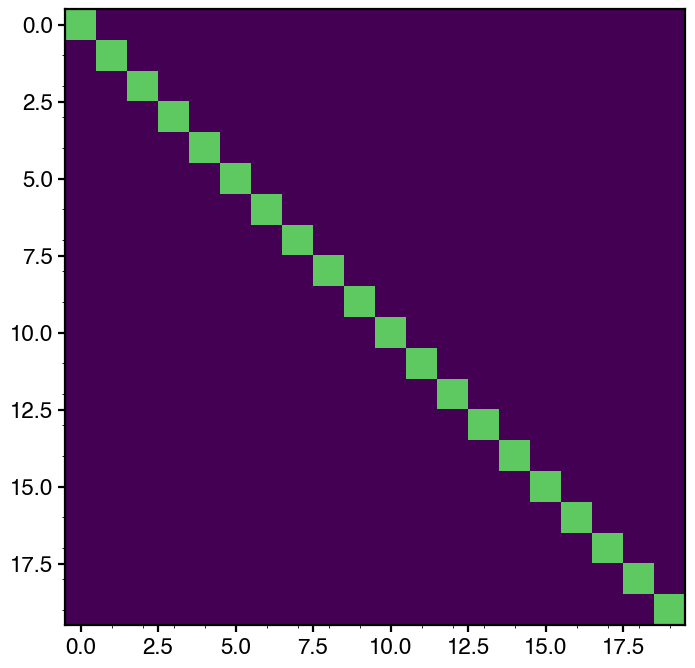

In [282]:
plot_transition_matrix(model,num_dists= 5,save_name=save_name)

Using 298 of 400 values in the transition matrix
Mean Uncertainty is: 0.3700972517913088
Bounds [0.  0.2 0.4 0.6 0.8 1. ], Labels [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]


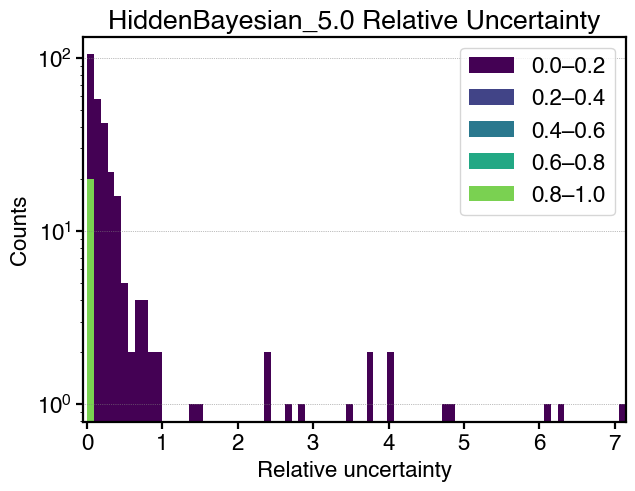

In [206]:
plot_transition_confidence_format(model,cutoff = 1e-6,num_dists= 5,num_bins=80,save_name=save_name)

Using 298 of 400 values in the transition matrix
Mean Uncertainty is: 0.3700972517913088
Bounds [0.  0.2 0.4 0.6 0.8 1. ], Labels [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]


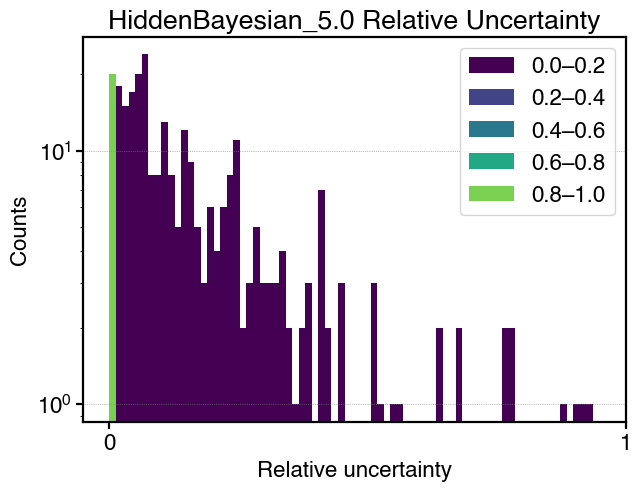

In [199]:
plot_transition_confidence_format(model,cutoff = 1e-6,num_dists= 5,num_bins=80,save_name=save_name,xmax=1)

In [114]:
np.save(f"{save_name}_hidden_trajectory.npy",model.hidden_state_trajectories)

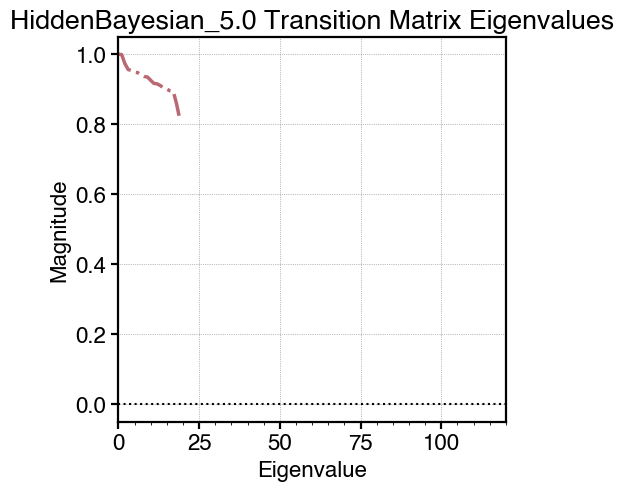

In [99]:
compute_eigenvalues(model,save_name = save_name)

[0.00745737 0.00164194 0.00352624 0.15365857 0.03295026 0.00721684
 0.02861356 0.03080442 0.00085346 0.00178454 0.09945579 0.04502126
 0.00857886 0.21365171 0.00790254 0.00979588 0.00034    0.22520432
 0.04218884 0.07935359]


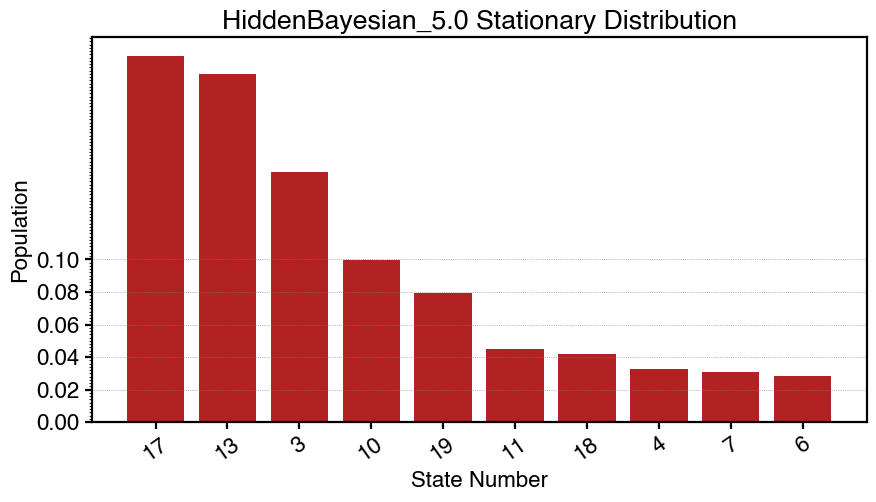

In [100]:
stationary_distributions(model,save_name = save_name)

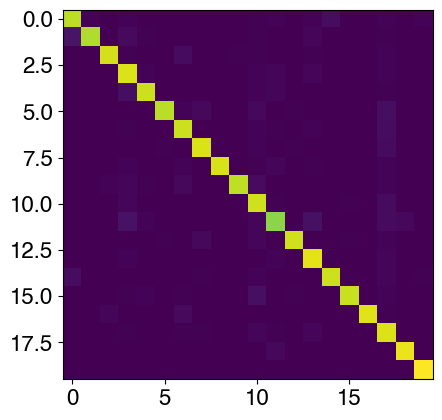

In [205]:
plt.imshow(model.transition_matrix)

Using 400 of 400 values in the transition matrix
(20, 20)


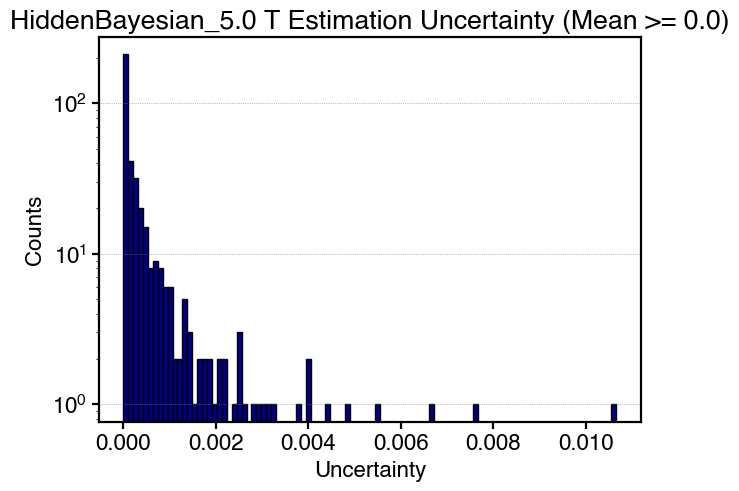

In [101]:
plot_transition_confidence(model,relative = False,save_name=save_name)

Using 67 of 400 values in the transition matrix
(20, 20)


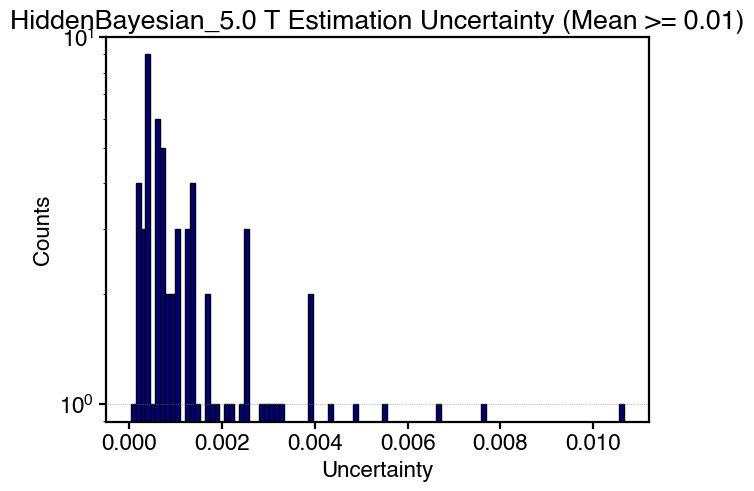

In [102]:
plot_transition_confidence(model,cutoff = 0.01,relative = False,save_name=save_name)

Using 298 of 400 values in the transition matrix
(20, 20)


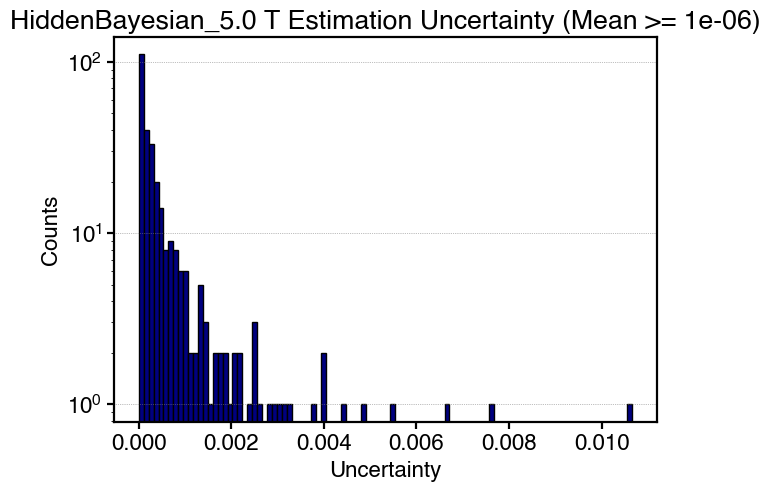

In [103]:
plot_transition_confidence(model,cutoff = 1e-6,relative = False,save_name=save_name)

Using 67 of 400 values in the transition matrix
(20, 20)


/var/folders/p5/bvpl53mn15v55f8v1vwk1fz80000gp/T/ipykernel_21296/919575753.py:12: RuntimeWarning: invalid value encountered in divide
  uncertainties = np.divide(uncertainties,means)


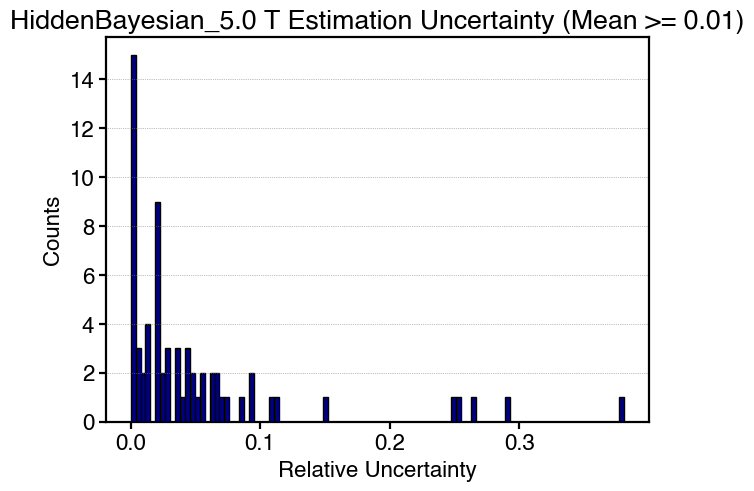

In [104]:
plot_transition_confidence(model,cutoff = 1e-6,relative = True,logy=False,save_name=save_name)

Using 298 of 400 values in the transition matrix
Mean Uncertainty is: 0.3700972517913088
Relative Uncertainty < 0.75: 
 Number of points: 274 
 Mean of mean transition probability: 0.07297654112266376
 Minimum mean transition probability: 1.2881471003826443e-05
 Maximum mean transition probability: 0.9984176018634112
Relative Uncertainty > 1.25: 
 Number of points: 16 
 Mean of mean transition probability: 1.6556261387675395e-05
 Minimum mean transition probability: 1.098714464551269e-06
 Maximum mean transition probability: 9.708703407945726e-05
Relative Uncertainty between 0.75 and 1.25: 
 Number of points: 8 
 Mean of mean transition probability: 0.0005197186708376681
 Minimum mean transition probability: 3.941662455559665e-06
 Maximum mean transition probability: 0.0023966316931840924


/var/folders/p5/bvpl53mn15v55f8v1vwk1fz80000gp/T/ipykernel_21296/1071764115.py:11: RuntimeWarning: invalid value encountered in divide
  uncertainties = np.divide(uncertainties,means)


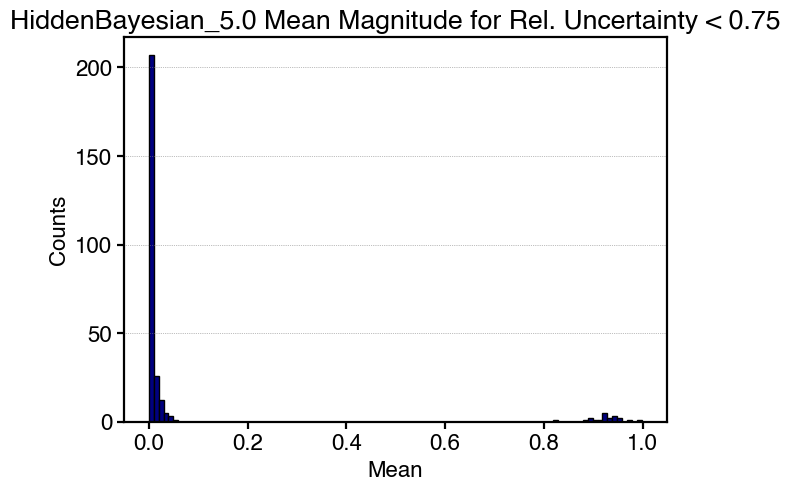

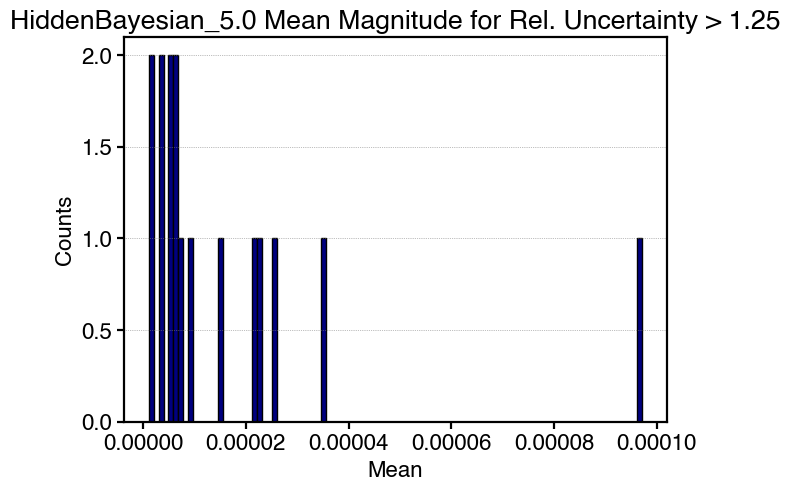

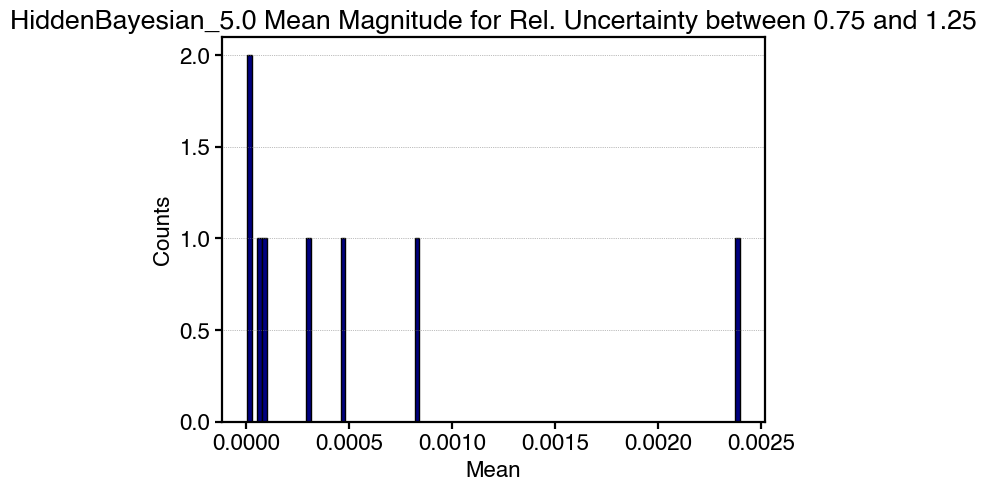

In [109]:
plot_meandist_from_confidence(model,cutoff = 1e-6,save_name=save_name)
#Note:

# Bayesian 3.5

In [232]:
file_path = "/Users/marcdescoteaux/Documents/04_Courses/AM207_StochasticMethods/Project/24_11_27_Analyze/models/Bayesian_3.5//model.file"
save_name2 = "Bayesian_3.5"
model2 = pyemma.load(file_path)


Bounds [0.   0.25 0.5  0.75 1.  ], Labels [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]


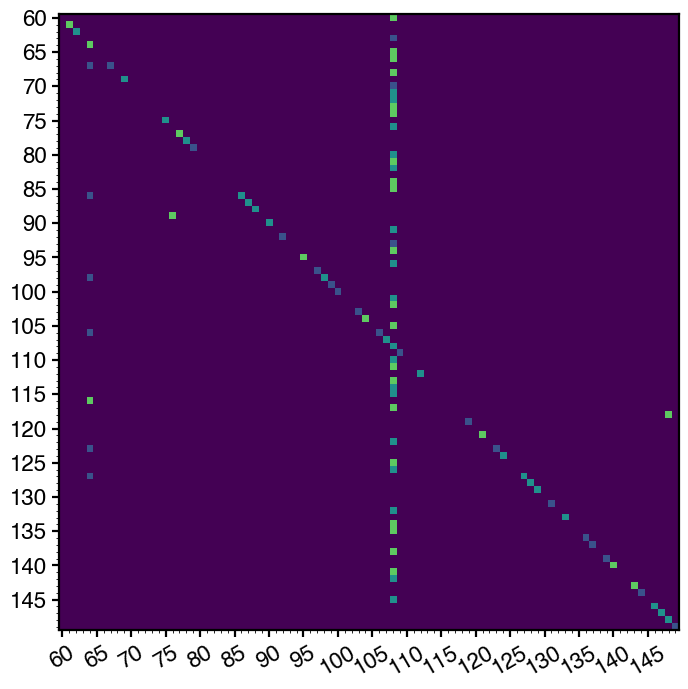

In [283]:
plot_transition_matrix(model2,num_dists= 5,zoom=((60,60),(150,150)),save_name=save_name2)

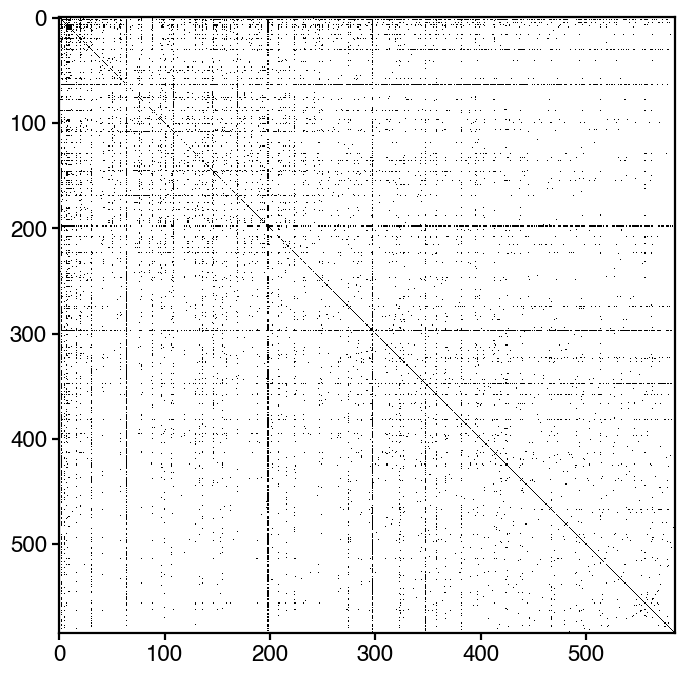

In [284]:
plot_transition_matrix_spy(model2,save_name=save_name2)

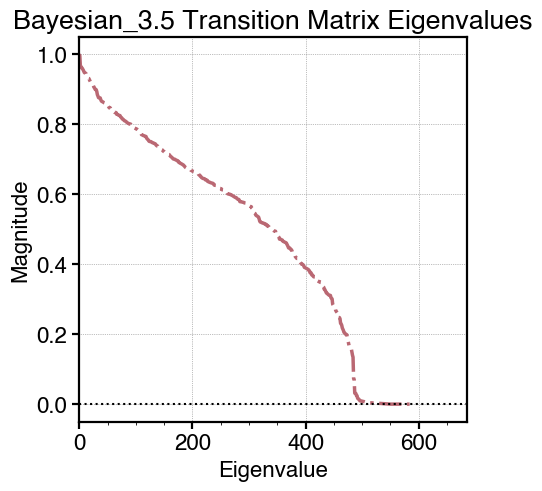

In [120]:
compute_eigenvalues(model2,save_name = save_name)

[1.26249888e-05 2.11558436e-05 1.99224393e-01 5.25772839e-04
 3.59300682e-05 3.95468142e-02 4.68569145e-05 1.55481721e-02
 1.21464600e-03 2.03347915e-03 1.61311998e-04 4.32639922e-04
 4.98268283e-04 2.88497742e-05 4.06809351e-05 1.32664562e-06
 3.69223387e-03 3.71851639e-05 7.39395296e-05 5.77280620e-05
 5.05426151e-03 4.52140535e-04 1.01248764e-06 3.99183762e-05
 2.62107196e-04 2.66817419e-06 7.26335871e-05 4.94685972e-04
 5.74480143e-06 2.81665655e-05 1.61551998e-02 9.86217971e-05
 1.16570464e-07 1.37040879e-05 1.96678927e-05 1.31116804e-04
 3.43851271e-05 1.80834306e-05 4.21612560e-05 1.77201742e-05
 2.74557417e-06 1.78222355e-03 2.68199188e-04 4.00718433e-05
 5.48856772e-05 7.24932250e-05 2.06147815e-05 1.04169354e-04
 9.21554555e-05 9.19539247e-05 1.31530225e-03 1.01074130e-06
 2.86188447e-04 1.90099266e-05 3.47647756e-05 3.34243649e-05
 7.43048520e-06 7.95537451e-05 6.13509576e-03 2.66880576e-05
 5.40536270e-06 2.71040111e-05 2.39516759e-05 3.04451474e-06
 1.88410208e-01 6.684167

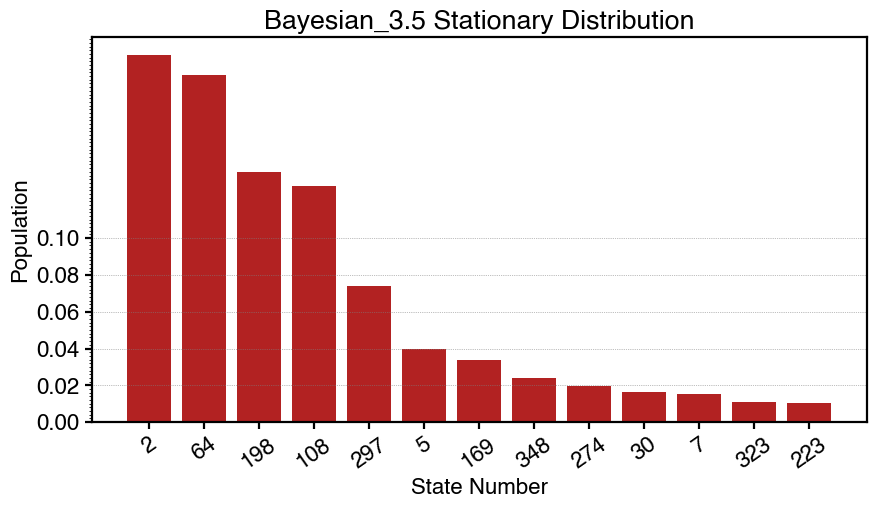

In [152]:
stationary_distributions(model,save_name = save_name)

Using 342225 of 342225 values in the transition matrix
(585, 585)


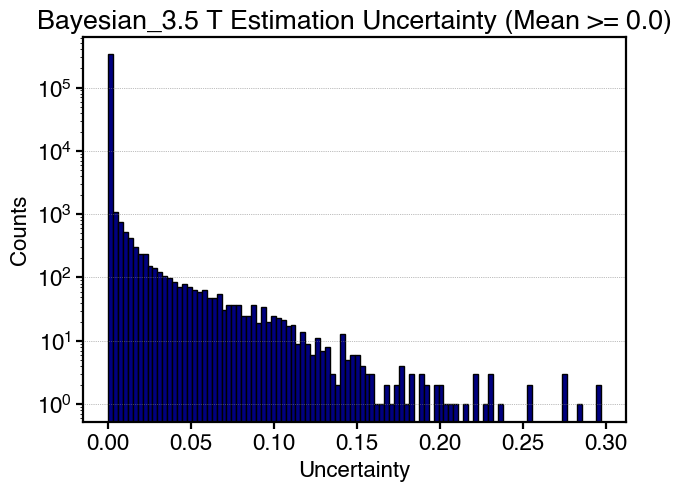

In [122]:
plot_transition_confidence(model,relative = False,save_name=save_name)

Using 3390 of 342225 values in the transition matrix
(585, 585)


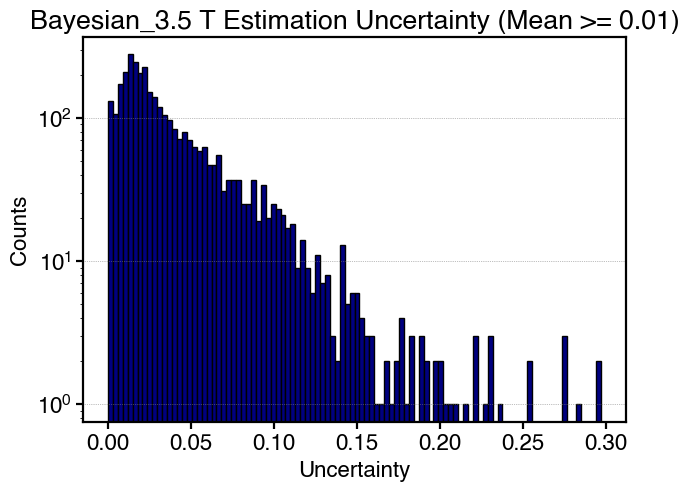

In [123]:
plot_transition_confidence(model,cutoff = 0.01,relative = False,save_name=save_name)

Using 11127 of 342225 values in the transition matrix
(585, 585)


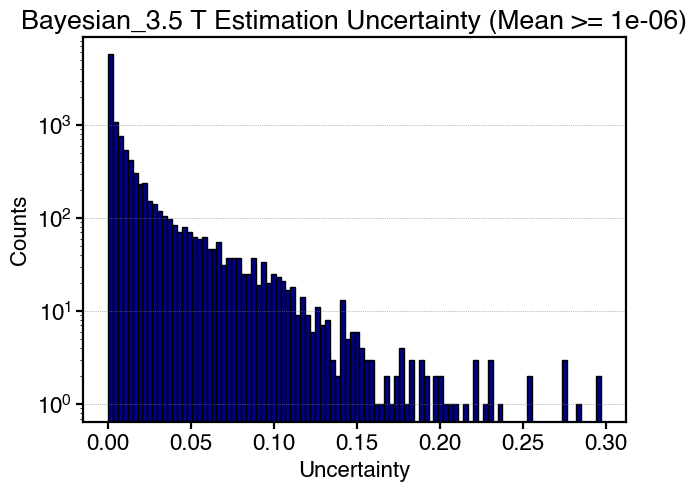

In [124]:
plot_transition_confidence(model,cutoff = 1e-6,relative = False,save_name=save_name)

Using 11127 of 342225 values in the transition matrix
Mean Uncertainty is: 1.121205548760818
Bounds [0.  0.2 0.4 0.6 0.8 1. ], Labels [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]


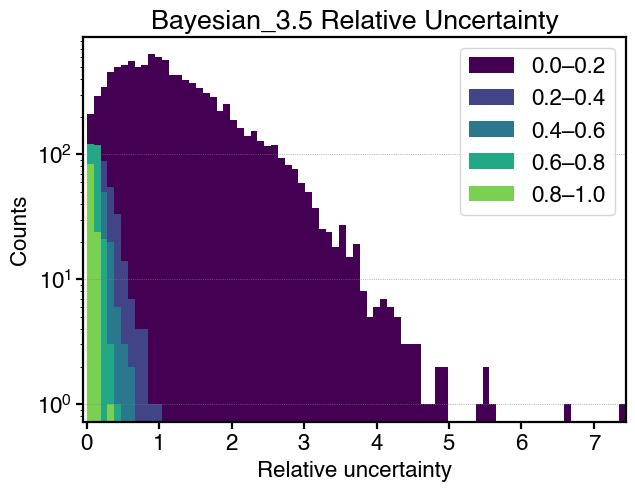

In [183]:
plot_transition_confidence_format(model,cutoff = 1e-6,num_dists= 5,save_name=save_name)

Using 11127 of 342225 values in the transition matrix
(585, 585)


/var/folders/p5/bvpl53mn15v55f8v1vwk1fz80000gp/T/ipykernel_21296/919575753.py:12: RuntimeWarning: invalid value encountered in divide
  uncertainties = np.divide(uncertainties,means)


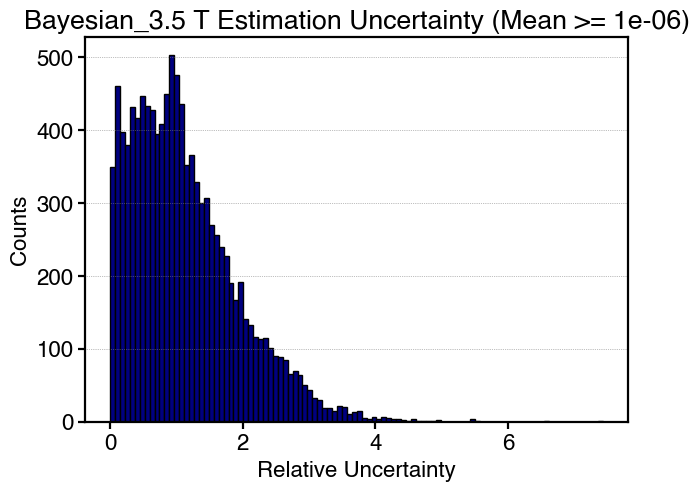

In [125]:
plot_transition_confidence(model,cutoff = 1e-6,relative = True,logy=False,save_name=save_name)

Using 11127 of 342225 values in the transition matrix
Mean Uncertainty is: 1.121205548760818
Relative Uncertainty < 0.75: 
 Number of points: 4170 
 Mean of mean transition probability: 0.12988497476972102
 Minimum mean transition probability: 1.5934840545089366e-06
 Maximum mean transition probability: 0.9999999999999993
Relative Uncertainty > 1.25: 
 Number of points: 4079 
 Mean of mean transition probability: 0.0030901061090120962
 Minimum mean transition probability: 1.0118713794529674e-06
 Maximum mean transition probability: 0.1537797820675045
Relative Uncertainty between 0.75 and 1.25: 
 Number of points: 2878 
 Mean of mean transition probability: 0.010693201305140142
 Minimum mean transition probability: 1.0052599961367879e-06
 Maximum mean transition probability: 0.2373048129017026


/var/folders/p5/bvpl53mn15v55f8v1vwk1fz80000gp/T/ipykernel_21296/1071764115.py:11: RuntimeWarning: invalid value encountered in divide
  uncertainties = np.divide(uncertainties,means)


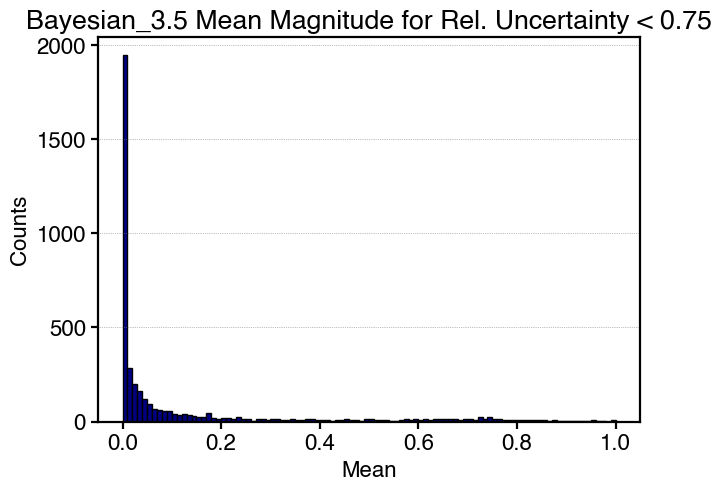

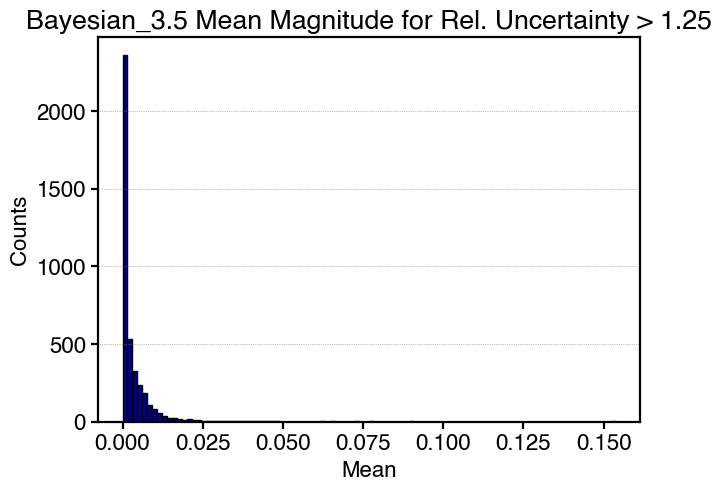

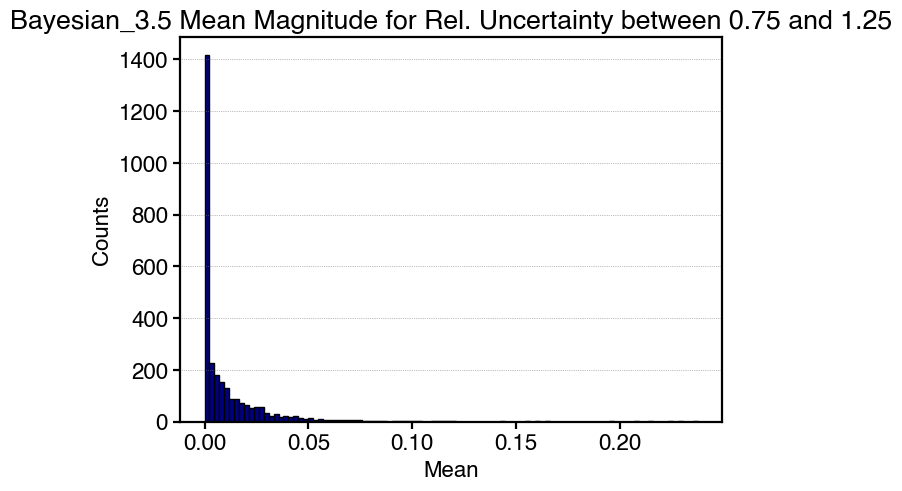

In [126]:
plot_meandist_from_confidence(model,cutoff = 1e-6,save_name=save_name)
#Note:

In [ ]:
plot_meandist_from_confidence(model,cutoff = 1e-6,save_name=save_name)

# Bayesian 3.5 Lag 10

In [135]:
file_path = "/Users/marcdescoteaux/Documents/04_Courses/AM207_StochasticMethods/Project/24_11_27_Analyze/models/Bayesian_3.5_lag10//model.file"
save_name = "Bayesian_3.5_lag10"
model = pyemma.load(file_path)


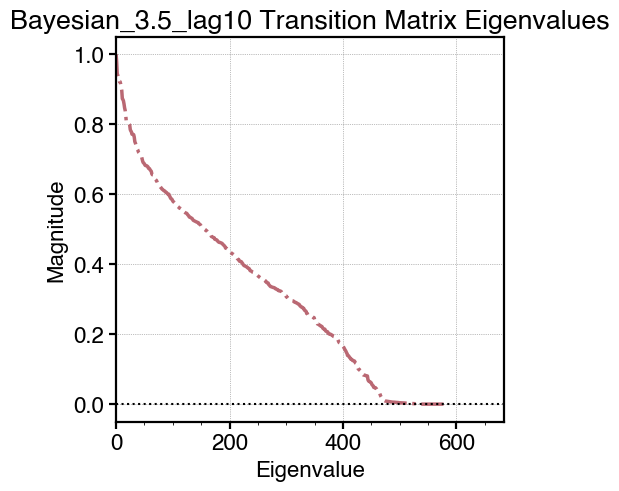

In [136]:
compute_eigenvalues(model,save_name = save_name)

[1.85048031e-05 2.51415179e-05 2.27073646e-01 4.04327479e-04
 4.40472498e-05 2.49321733e-02 5.35937778e-05 1.87459130e-02
 1.51455156e-03 2.38827277e-03 2.17132348e-04 5.20418706e-04
 5.90930362e-04 4.00326415e-05 4.40543431e-05 6.58399986e-07
 4.26126819e-03 9.80652624e-05 7.00977992e-05 7.58625783e-05
 6.09338825e-03 3.12776664e-04 2.04734683e-07 4.06856511e-05
 3.10525900e-04 1.49435325e-06 8.02404034e-05 5.62784444e-04
 4.68544560e-06 3.65090274e-05 1.99560795e-02 1.21376659e-04
 1.63596330e-08 1.59908239e-05 2.03181982e-05 1.21212003e-04
 3.82103818e-05 2.23769162e-05 5.17468950e-05 9.76695665e-06
 9.60239819e-07 1.07695548e-03 3.14806617e-04 5.42242521e-05
 6.94608762e-05 8.97646641e-05 1.94143153e-05 5.26730449e-05
 1.23879432e-04 1.09886609e-04 6.85692046e-04 4.26766755e-07
 3.84279829e-04 2.33098106e-05 3.33753066e-05 5.40426416e-05
 3.93265662e-06 1.02578673e-04 3.95365109e-03 3.08545270e-05
 3.72785480e-06 3.39511955e-05 2.40467006e-05 1.91136889e-06
 2.22906838e-01 2.944707

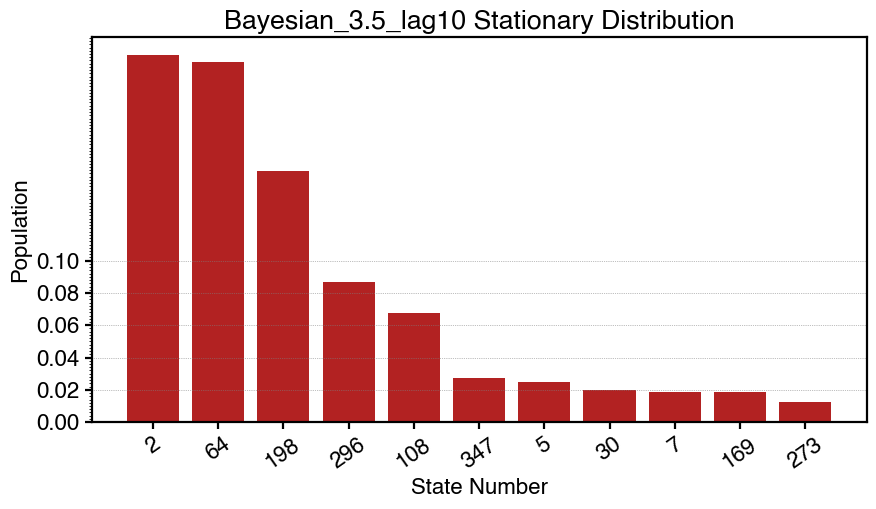

In [137]:
stationary_distributions(model,save_name = save_name)

Using 339889 of 339889 values in the transition matrix
(583, 583)


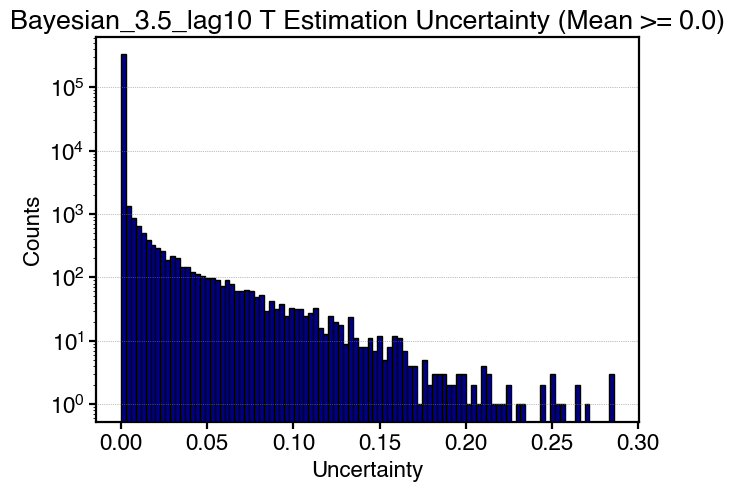

In [138]:
plot_transition_confidence(model,relative = False,save_name=save_name)

Using 4549 of 339889 values in the transition matrix
(583, 583)


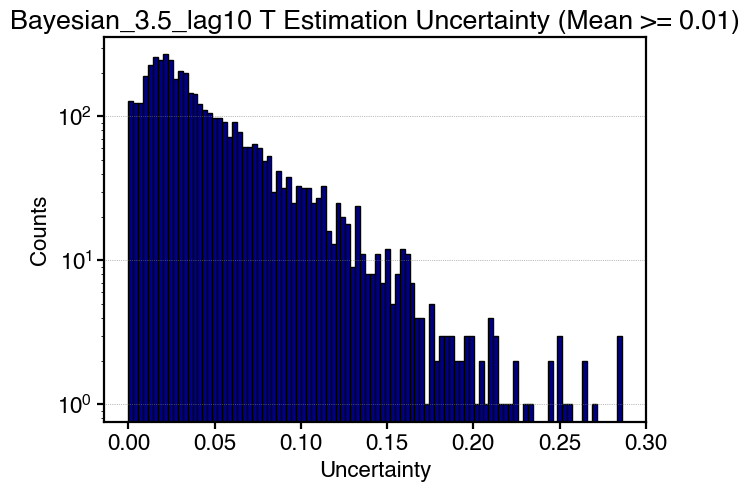

In [139]:
plot_transition_confidence(model,cutoff = 0.01,relative = False,save_name=save_name)

Using 15056 of 339889 values in the transition matrix
(583, 583)


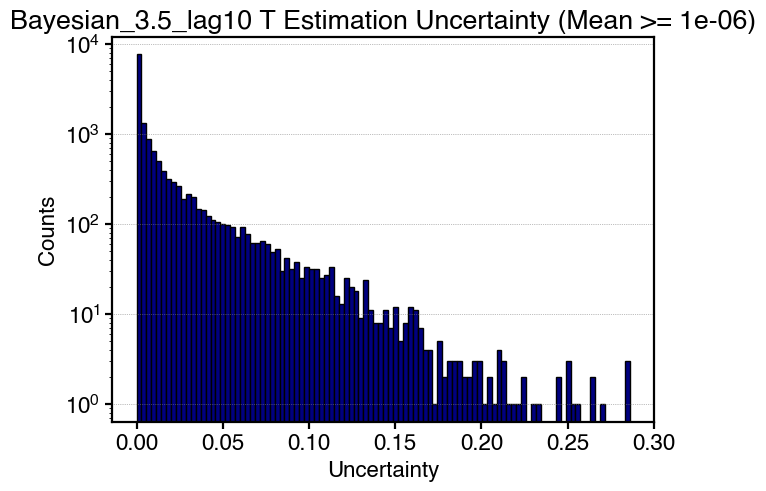

In [140]:
plot_transition_confidence(model,cutoff = 1e-6,relative = False,save_name=save_name)

Using 15056 of 339889 values in the transition matrix
(583, 583)


/var/folders/p5/bvpl53mn15v55f8v1vwk1fz80000gp/T/ipykernel_21296/919575753.py:12: RuntimeWarning: invalid value encountered in divide
  uncertainties = np.divide(uncertainties,means)


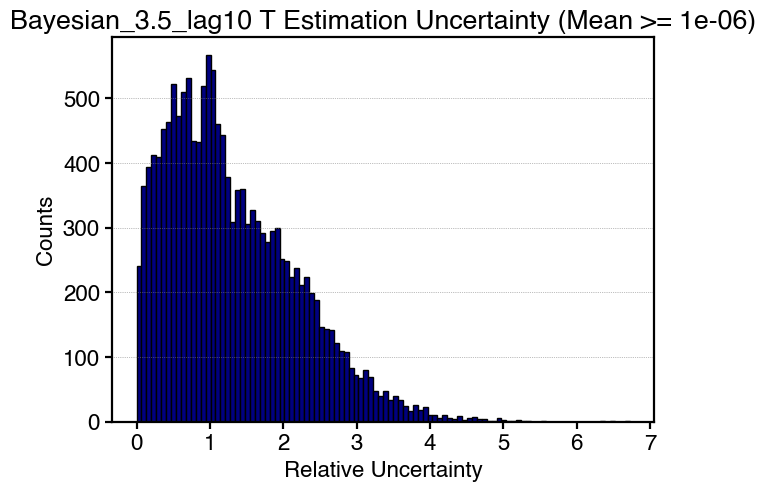

In [141]:
plot_transition_confidence(model,cutoff = 1e-6,relative = True,logy=False,save_name=save_name)

Using 15056 of 339889 values in the transition matrix
Mean Uncertainty is: 1.2991498688028376
Relative Uncertainty < 0.75: 
 Number of points: 4829 
 Mean of mean transition probability: 0.10387876385507379
 Minimum mean transition probability: 1.0739292112138555e-06
 Maximum mean transition probability: 0.9999999999999991
Relative Uncertainty > 1.25: 
 Number of points: 6667 
 Mean of mean transition probability: 0.003779175423026686
 Minimum mean transition probability: 1.0352273828520966e-06
 Maximum mean transition probability: 0.17962173050387178
Relative Uncertainty between 0.75 and 1.25: 
 Number of points: 3560 
 Mean of mean transition probability: 0.01577910136235644
 Minimum mean transition probability: 1.0349172687207236e-06
 Maximum mean transition probability: 0.3115984977298086


/var/folders/p5/bvpl53mn15v55f8v1vwk1fz80000gp/T/ipykernel_21296/1071764115.py:11: RuntimeWarning: invalid value encountered in divide
  uncertainties = np.divide(uncertainties,means)


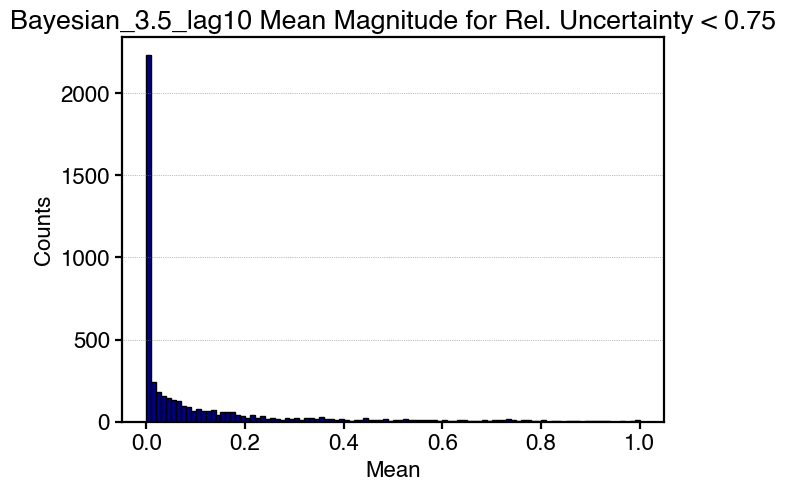

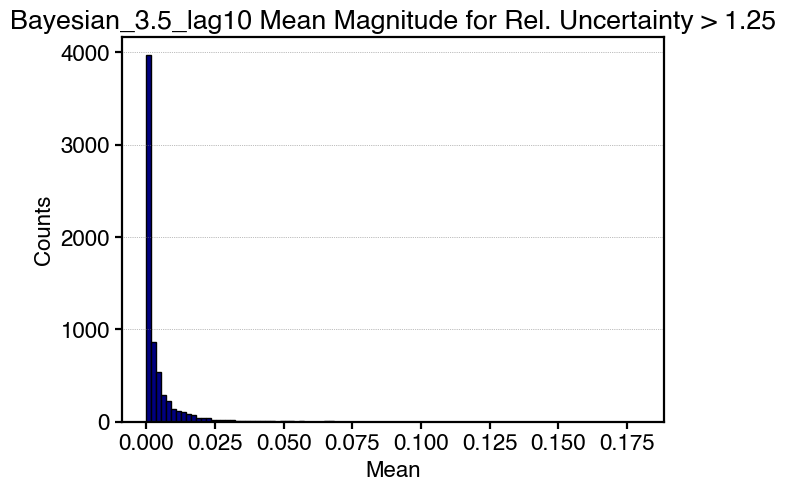

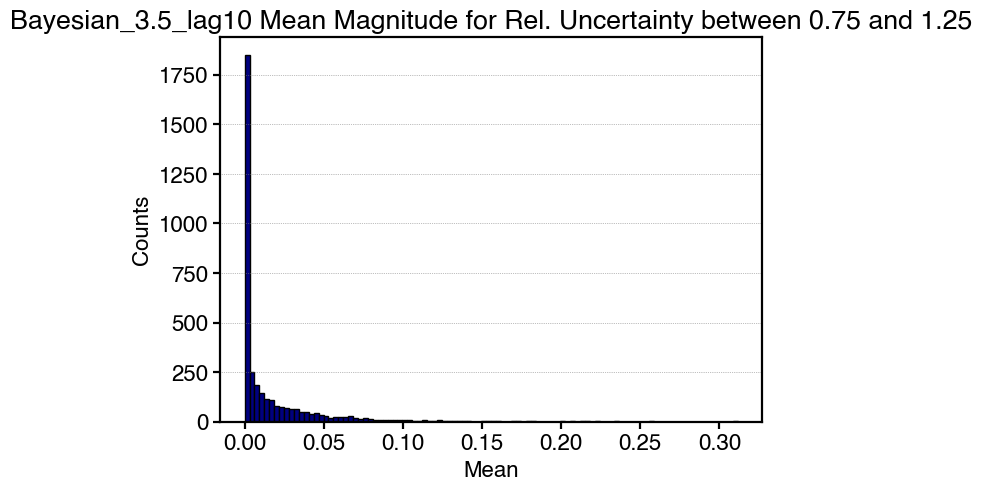

In [142]:
plot_meandist_from_confidence(model,cutoff = 1e-6,save_name=save_name)
#Note:

# Bayesian 3.5 lag 25

In [127]:
file_path = "/Users/marcdescoteaux/Documents/04_Courses/AM207_StochasticMethods/Project/24_11_27_Analyze/models/Bayesian_3.5_lag25//model.file"
save_name = "Bayesian_3.5_lag25"
model = pyemma.load(file_path)


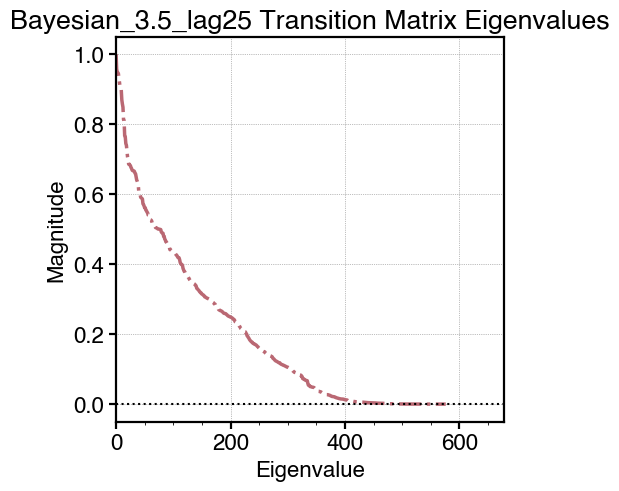

In [128]:
compute_eigenvalues(model,save_name = save_name)

[2.05193280e-05 3.33544009e-05 2.37388163e-01 3.11546996e-04
 4.85327386e-05 1.67513295e-02 6.06132290e-05 2.02094394e-02
 1.61984668e-03 2.52089660e-03 1.80359970e-04 4.90085372e-04
 6.40001881e-04 3.41209667e-05 4.58880505e-05 3.74606863e-07
 4.40513943e-03 1.28502202e-04 5.40390336e-05 8.22588043e-05
 6.51327003e-03 2.46116944e-04 6.79198949e-07 3.64519345e-05
 3.31814891e-04 9.86915501e-07 1.03130748e-04 6.07041646e-04
 4.35544856e-06 4.08988563e-05 2.16059035e-02 1.59209027e-04
 4.55873745e-08 1.92063410e-05 2.54142229e-05 1.11394509e-04
 4.58424557e-05 3.49626720e-05 4.93381760e-05 5.83711283e-06
 6.75558291e-07 7.18365842e-04 3.41126963e-04 6.80229678e-05
 7.86343754e-05 1.00221233e-04 1.66222751e-05 3.41204575e-05
 1.45930500e-04 1.33267048e-04 4.33196281e-04 3.00830918e-07
 4.00584940e-04 2.59448046e-05 4.30857310e-05 7.60142859e-05
 2.52808619e-06 1.12223941e-04 3.06813958e-03 3.18960242e-05
 2.06063726e-06 3.69317819e-05 2.49549388e-05 1.56380895e-06
 2.38168542e-01 1.562285

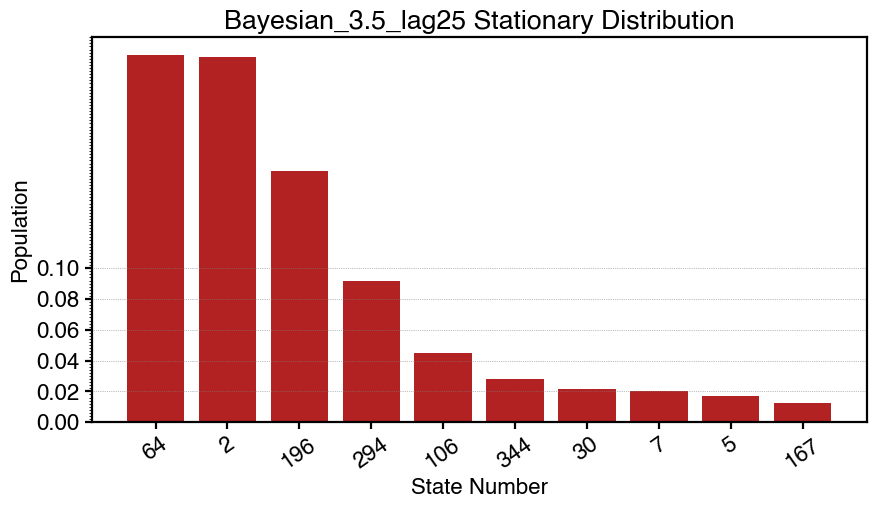

In [129]:
stationary_distributions(model,save_name = save_name)

Using 332929 of 332929 values in the transition matrix
(577, 577)


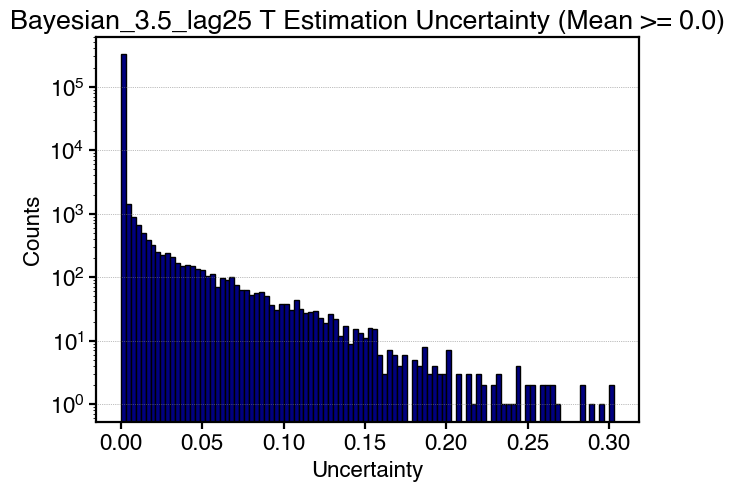

In [130]:
plot_transition_confidence(model,relative = False,save_name=save_name)

Using 4599 of 332929 values in the transition matrix
(577, 577)


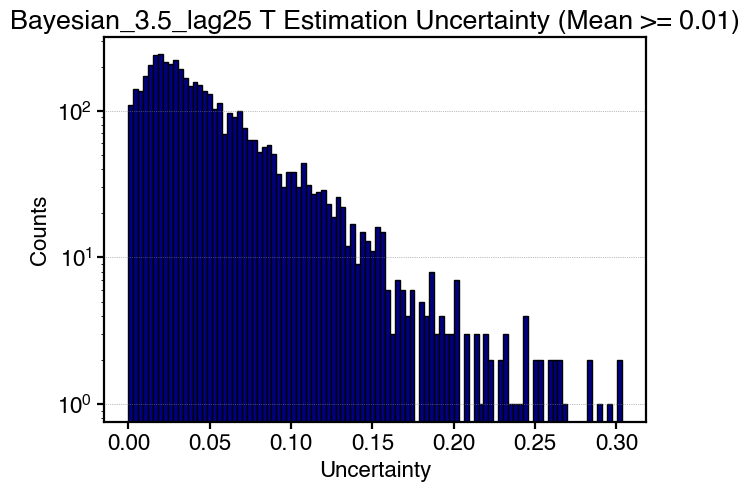

In [131]:
plot_transition_confidence(model,cutoff = 0.01,relative = False,save_name=save_name)

Using 15859 of 332929 values in the transition matrix
(577, 577)


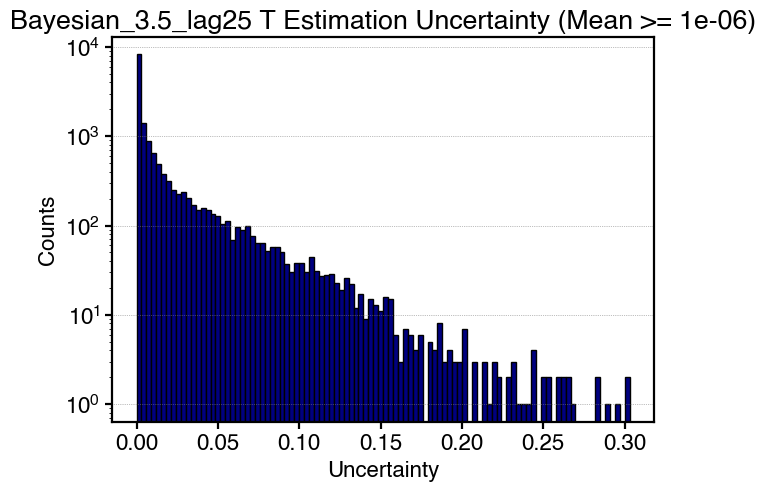

In [132]:
plot_transition_confidence(model,cutoff = 1e-6,relative = False,save_name=save_name)

Using 15859 of 332929 values in the transition matrix
(577, 577)


/var/folders/p5/bvpl53mn15v55f8v1vwk1fz80000gp/T/ipykernel_21296/919575753.py:12: RuntimeWarning: invalid value encountered in divide
  uncertainties = np.divide(uncertainties,means)


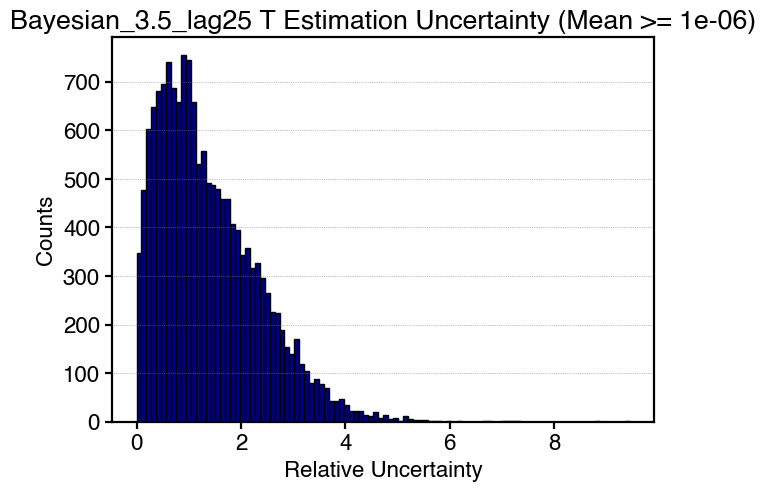

In [133]:
plot_transition_confidence(model,cutoff = 1e-6,relative = True,logy=False,save_name=save_name)

Using 15859 of 332929 values in the transition matrix
Mean Uncertainty is: 1.3855711143474332
Relative Uncertainty < 0.75: 
 Number of points: 4853 
 Mean of mean transition probability: 0.10043621276397206
 Minimum mean transition probability: 1.243210622997919e-06
 Maximum mean transition probability: 0.9999999999999973
Relative Uncertainty > 1.25: 
 Number of points: 7499 
 Mean of mean transition probability: 0.00415090199069137
 Minimum mean transition probability: 1.0038111940160673e-06
 Maximum mean transition probability: 0.1586118177618915
Relative Uncertainty between 0.75 and 1.25: 
 Number of points: 3507 
 Mean of mean transition probability: 0.016668195253450112
 Minimum mean transition probability: 1.043582260150636e-06
 Maximum mean transition probability: 0.3323690327850211


/var/folders/p5/bvpl53mn15v55f8v1vwk1fz80000gp/T/ipykernel_21296/1071764115.py:11: RuntimeWarning: invalid value encountered in divide
  uncertainties = np.divide(uncertainties,means)


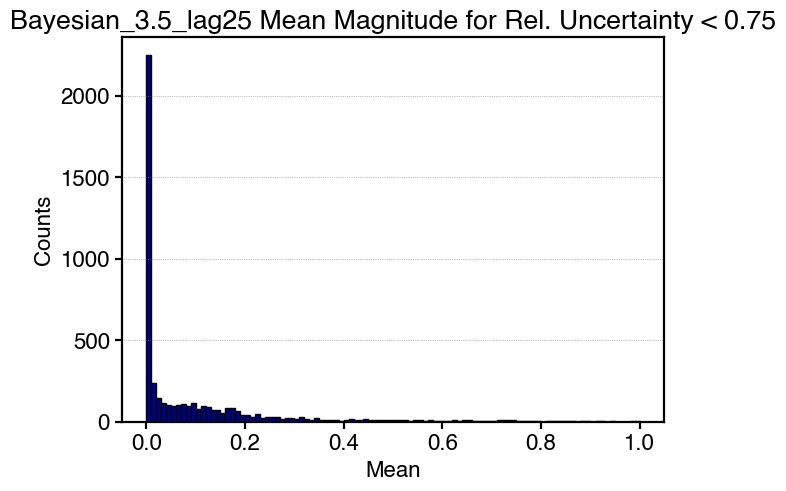

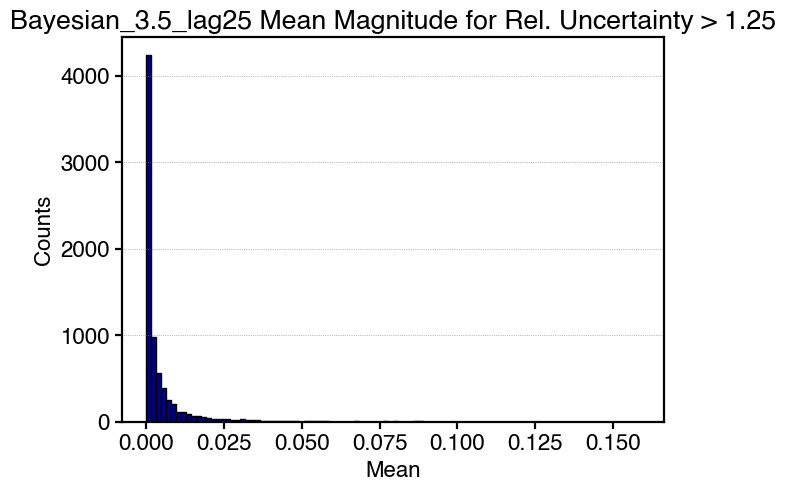

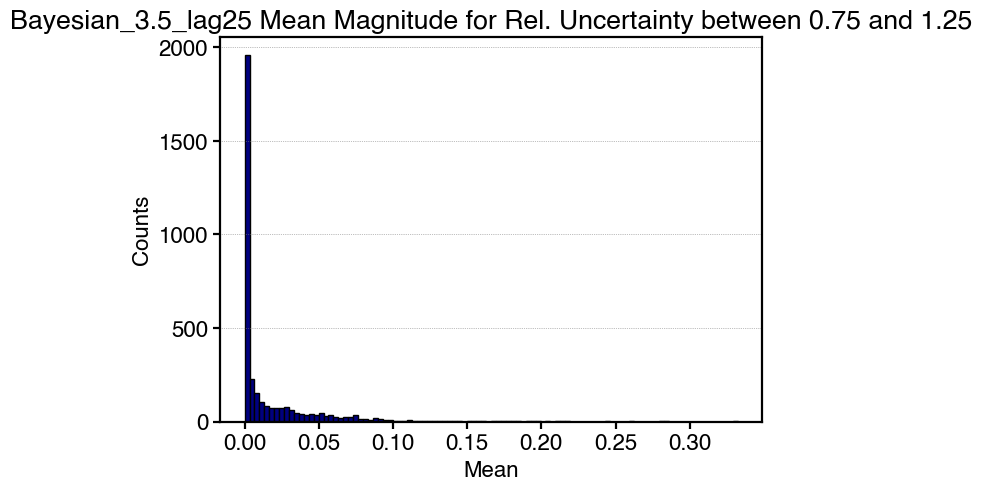

In [134]:
plot_meandist_from_confidence(model,cutoff = 1e-6,save_name=save_name)
#Note:

# Additional Analyses

In [1]:
def compute_eigenvalues(msm,save_name = ""):
    '''
    Plots the eigenspectrum of the markov model's transition matrix
    '''
    eigenvalues = msm.eigenvalues()
    
    
    
    plt.rcParams.update({"font.size": 16})
    plt.rcParams.update({"font.family": "Helvetica"})
    plt.rcParams.update({"font.style": "normal"})
    
    plt.figure(figsize=(5,5))
    plt.plot(np.arange(len(eigenvalues)),np.abs(eigenvalues),color = "xkcd:dusky rose",linewidth=2.5,linestyle ="-." )
    plt.title(f"{save_name} Transition Matrix Eigenvalues")
    plt.xlabel("Eigenvalue")
    plt.ylabel("Magnitude")
    plt.minorticks_on()
    ax = plt.gca()

    ax.yaxis.set_minor_locator(MultipleLocator(5))
    ax.grid(color="grey", linestyle=":", linewidth=0.5)
    for axis in ["bottom", "top", "left", "right"]:
        ax.spines[axis].set_linewidth(1.6)
    ax.xaxis.set_tick_params(width=1.6, length=5)
    ax.yaxis.set_tick_params(width=1.6, length=5)
    plt.ylim(-0.05,1.05)
    plt.xlim(-0.05,len(eigenvalues)+10)
    plt.hlines(0,-0.05,len(eigenvalues)+10,color = "black",linestyle = ":")
    plt.savefig(save_name+"_eigenvalues.png",dpi=300)
    

In [2]:
def pcca(msm,num_states,save_name = ""):
    '''
    Performs Perron-cluster cluster analysis of the markov model to reduce the complexity.
    '''
    clustering = msm.pcca(num_states)
    assignments = clustering.metastable_assignment
    new_transition_matrix = clustering.coarse_grained_transition_matrix 
    print(new_transition_matrix)
    
    plt.imshow(new_transition_matrix,cmap = cmaps["cividis"])
    plt.savefig(save_name+"_pcca_transition_matrix.png",dpi=300)
    
    
    return clustering

In [3]:
def plot_network(msm,save_name = ""):
    '''
    Plots a graph and edges between states in the markov model
    '''
    
    num_states = msm.coarse_grained_transition_matrix.shape[0]
    
    transition_matrix = msm.coarse_grained_transition_matrix
    
    transition_matrix[transition_matrix < 0.01] = 0
    transition_matrix = transition_matrix*100
    positions = np.zeros((num_states,2))
    for state in range(num_states):
        positions[state,0] = np.cos(2*np.pi*(state)/num_states)
        positions[state,1] = np.sin(2*np.pi*(state)/num_states)
    
    fig, pos = pyemma.plots.plot_network(transition_matrix,pos = positions,show_frame = False,arrow_label_format='%2f')
    
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    ax = plt.gca()
    ax.grid(color="grey", linestyle=":", linewidth=0.5)
    for axis in ["bottom", "top", "left", "right"]:
        ax.spines[axis].set_linewidth(1.6)
    ax.xaxis.set_tick_params(width=1.6, length=5)
    ax.yaxis.set_tick_params(width=1.6, length=5)
    plt.savefig(save_name+"_network.png",dpi=300)
    plt.show()
    
    
    return

In [4]:
def plot_transition_confidence(msm,relative = False,cutoff = 0.0,logy=True,save_name = ""):
    '''
    Plots the relative uncertainty distribution of the elements of the Markov model's transition matrix.
    '''
    
    uncertainties = msm.sample_std("transition_matrix")
    means = msm.sample_mean("transition_matrix")
    mask = means >= cutoff
    
    print(f"Using {np.sum(mask)} of {uncertainties.size} values in the transition matrix")
    
    if relative:
        assert cutoff > 0.0
        uncertainties = np.divide(uncertainties,means)
    
    print(uncertainties.shape)
    uncertainties = uncertainties[mask].flatten()
    num_bins = 100
    counts, bins = np.histogram(uncertainties, bins=num_bins)

    
    
    plt.figure(figsize=(7,5))
    plt.hist(
        bins[:-1],
        bins,
        weights=counts,
        rwidth=1.0,
        edgecolor="black",
        color="navy",
        label="Transition uncertainties",
        density=False,
    )
    plt.title(f"{save_name} T Estimation Uncertainty (Mean >= {cutoff})")
    if relative:
        plt.xlabel("Relative Uncertainty")
    else:
        plt.xlabel("Uncertainty")
    plt.ylabel("Counts")

    ax = plt.gca()
    if logy:
        ax.set_yscale('log')

    ax.grid(color="grey", linestyle=":", linewidth=0.5,axis="y")
    for axis in ["bottom", "top", "left", "right"]:
        ax.spines[axis].set_linewidth(1.6)
    ax.xaxis.set_tick_params(width=1.6, length=5)
    ax.yaxis.set_tick_params(width=1.6, length=5)

    
    plt.savefig(save_name+f"_uncertainty_{cutoff}_relative-{relative}_logy-{logy}.png",dpi=300)

In [7]:
def plot_meandist_from_confidence(msm,relative = True,cutoff = 0.01,logy=False,save_name = ""):
    '''
    More hard coded version of the function at the top of the nodebook. Separates relative uncertainties by their magnitude, 
    then plots the distribution of means associated with those relative uncertainties for each group.
    '''
    uncertainties = msm.sample_std("transition_matrix")
    means = msm.sample_mean("transition_matrix")
    mask = means >= cutoff
    
    print(f"Using {np.sum(mask)} of {uncertainties.size} values in the transition matrix")
    
    if relative:
        assert cutoff > 0.0
        uncertainties = np.divide(uncertainties,means)
    print("Mean Uncertainty is:",np.mean(uncertainties[mask]))

    try:
        means_075 = means[(uncertainties<0.75) & mask]
        means_075.flatten()
        print(f"Relative Uncertainty < 0.75: \n Number of points: {len(means_075)} \n Mean of mean transition probability: {np.mean(means_075)}\n Minimum mean transition probability: {np.min(means_075)}\n Maximum mean transition probability: {np.max(means_075)}")
        using_small = True
    except:
        using_small = False
    try:
        means_125 = means[(uncertainties>1.25) & mask]
        means_125.flatten()
        print(f"Relative Uncertainty > 1.25: \n Number of points: {len(means_125)} \n Mean of mean transition probability: {np.mean(means_125)}\n Minimum mean transition probability: {np.min(means_125)}\n Maximum mean transition probability: {np.max(means_125)}")
        using_large = True
    except:
        using_large = False
        
    try:
        means_100 = means[((uncertainties>=0.75) & (uncertainties<=1.25)) & mask]
        means_100.flatten()
        print(f"Relative Uncertainty between 0.75 and 1.25: \n Number of points: {len(means_100)} \n Mean of mean transition probability: {np.mean(means_100)}\n Minimum mean transition probability: {np.min(means_100)}\n Maximum mean transition probability: {np.max(means_100)}")
        using_medium = True
    except:
        using_medium=False
    num_bins = 100
    
    if using_small:
        #Small values:
        counts, bins = np.histogram(means_075, bins=num_bins)
        plt.figure(figsize=(7,5))
        plt.hist(
            bins[:-1],
            bins,
            weights=counts,
            rwidth=1.0,
            edgecolor="black",
            color="navy",
            label="Transition uncertainties",
            density=False,
        )
        
        plt.title(f"{save_name} Mean Magnitude for Rel. Uncertainty < 0.75")
        plt.xlabel("Mean")
        plt.ylabel("Counts")
        ax = plt.gca()
        if logy:
            ax.set_yscale('log')
        ax.grid(color="grey", linestyle=":", linewidth=0.5,axis="y")
        for axis in ["bottom", "top", "left", "right"]:
            ax.spines[axis].set_linewidth(1.6)
        ax.xaxis.set_tick_params(width=1.6, length=5)
        ax.yaxis.set_tick_params(width=1.6, length=5)    
        plt.savefig(save_name+f"_uncertainty_{cutoff}_mean0.75_logy{logy}.png",dpi=300)
        plt.show()
    if using_large:
        #Large values:
        counts, bins = np.histogram(means_125, bins=num_bins)
        plt.figure(figsize=(7,5))
        plt.hist(
            bins[:-1],
            bins,
            weights=counts,
            rwidth=1.0,
            edgecolor="black",
            color="navy",
            label="Transition uncertainties",
            density=False,
        )
        
        plt.title(f"{save_name} Mean Magnitude for Rel. Uncertainty > 1.25")
        plt.xlabel("Mean")
        plt.ylabel("Counts")
        ax = plt.gca()
        if logy:
            ax.set_yscale('log')
        ax.grid(color="grey", linestyle=":", linewidth=0.5,axis="y")
        for axis in ["bottom", "top", "left", "right"]:
            ax.spines[axis].set_linewidth(1.6)
        ax.xaxis.set_tick_params(width=1.6, length=5)
        ax.yaxis.set_tick_params(width=1.6, length=5)    
        plt.savefig(save_name+f"_uncertainty_{cutoff}_mean1.25_logy{logy}.png",dpi=300)
        plt.show()
    if using_medium:
        #Middle values:
        counts, bins = np.histogram(means_100, bins=num_bins)
        plt.figure(figsize=(7,5))
        plt.hist(
            bins[:-1],
            bins,
            weights=counts,
            rwidth=1.0,
            edgecolor="black",
            color="navy",
            label="Transition uncertainties",
            density=False,
        )
        plt.title(f"{save_name} Mean Magnitude for Rel. Uncertainty between 0.75 and 1.25")
        plt.xlabel("Mean")
        plt.ylabel("Counts")
        ax = plt.gca()
        if logy:
            ax.set_yscale('log')
        ax.grid(color="grey", linestyle=":", linewidth=0.5,axis="y")
        for axis in ["bottom", "top", "left", "right"]:
            ax.spines[axis].set_linewidth(1.6)
        ax.xaxis.set_tick_params(width=1.6, length=5)
        ax.yaxis.set_tick_params(width=1.6, length=5)    
        plt.savefig(save_name+f"_uncertainty_{cutoff}_mean1.00_logy{logy}.png",dpi=300)
        plt.show()
    
    